# Calculate ciCOH Values: 

* For both normal and mild LFP data 

* Reach phase [reachonset touch] in single kluverboard task

* [9 11]Hz

## Import Packages

In [1]:
import os, sys
import scipy.io as sio
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle 
%matplotlib inline

In [2]:
# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)

# import_nbmodule used for import package in .ipynb
import import_nbmodule

# import util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

# import ciCoherence_overtime in connAnalyTool/synchronization_indices.ipynb
from connAnalyTool.synchronization_indices import ciCoherence_acrosstrials
from connAnalyTool.synchronization_indices import ciCoherence_overtime

importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb
importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb


## exp subfolders & code_corresfolder

In [3]:
_, _, pipelinefolder, _= exp_subfolders()

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

# corresfolder
corresfolder, correparentfolder = code_corresfolder(os.getcwd(), nb_name)

## input setup

In [6]:
inputfolder = os.path.join(correparentfolder, 'old metadata','m0_STKData_narrowfiltered9_11')

## global parameters

In [7]:
freq = [9, 11]

eventphase = 'reach'

animal = 'Pinky'

tdur_min, tdur_max = 0.5, 1
tdur_reach = tdur_min

In [8]:
leadSTN_chns, leadGP_chns = [5,6], [6, 7]

In [9]:
coli_target, coli_reachonset, coli_touch, coli_returnonset, coli_mouth = 0, 1, 2, 3, 4


if eventphase == 'reach':
    cols = [coli_reachonset, coli_touch]
    
elif eventphase == 'return':
    cols = [coli_returnonset, coli_mouth]

## save file setup

In [10]:
savefolder = corresfolder
savefilename =  'ciCOH_STK_freq' + str(freq[0]) + '_' + str(freq[1]) + eventphase +'.pickle'
savefile_ciCOH = os.path.join(savefolder, savefilename)

## extract lfp 
from all the files in mild or normal condition

### extract lfpnormal_alltrials, lfpmild_alltrials

In [11]:
## glob all .mat files (both mild and normal files)
files = glob.glob(os.path.join(inputfolder, '*.mat'))

### combine the trials from all the files that last longer than tdur_min and less than tdur_max ###
for filei, file in enumerate(files):
    
    # load the stk trial data in alpha band with idxevent, idxevent_varNames, fs
    matdat = sio.loadmat(file, 
                         variable_names = ['lfpdata', 'chnsarea_Cell', 'chnsarea_vNames',
                                           'idxevent_Matrix' ,'idxevent_vNames','fs'], 
                         struct_as_record = False, squeeze_me = True)
    # fs: sample rate
    fs = matdat['fs'] 
    # idxevent (np.ndarray, ntrials * 5) indices for targetonset, reachonset, reach, return and mouth
    idxevent, idxevent_varNames = matdat['idxevent_Matrix'], matdat['idxevent_vNames'] 
    # chnsarea, and chnsarea_varNames: channel and brain area information
    chnsarea, chnsarea_varNames = matdat['chnsarea_Cell'], matdat['chnsarea_vNames']         
    # lfp
    lfp = matdat['lfpdata']
    
    
    if 'idx_notused' not in locals():
        # remove channels not used for any brain area    
        coli_brainarea = np.where(chnsarea_varNames =='brainarea')[0][0]
        brainareas = chnsarea[coli_brainarea] # brainareas column
        idx_notused = [] 
        for idx, area in enumerate(brainareas):
            if isinstance(area, str) is not True:
                idx_notused.append(idx)
        # remove the chnsarea row of the not used idx
        chnsarea_used = np.copy(chnsarea)
        for i in range(chnsarea.shape[0]):
            chnsarea_used[i] = np.delete(chnsarea[i], idx_notused)
            
        del coli_brainarea, brainareas, idx, area, i
            
        
        idxdur_min, idxdur_max = int(np.round(tdur_min * fs)), int(np.round(tdur_max * fs))
        idxdur_reach = int(np.round(tdur_reach * fs))
    
    # remove the lfp data, chnsarea of the not used idx        
    lfp = np.delete(lfp, idx_notused, 0)
    
    if len(lfp.shape) == 2: # only has one trial
        lfp = np.expand_dims(lfp, axis = 2)
        idxevent = np.expand_dims(idxevent, axis = 0)
    
    ntrials = lfp.shape[2]
    
    # deal each trial in lfp of one file
    for triali in range(ntrials):
        
        # start and end indices over time of specific phase for triali 
        idxtime_str, idxtime_end = int(idxevent[triali][cols[0]]), int(idxevent[triali][cols[1]])    
        
        # remove trials of reach phase longer than tdur_max and shorter than tdur_min
        if idxtime_end - idxtime_str < idxdur_min or idxtime_end - idxtime_str > idxdur_max:
            continue;
            
            
        # extract lfp data in specific phase of one trial (n_chns * n_times)
        lfp_1trial = np.expand_dims(lfp[:, idxtime_str:idxtime_str + idxdur_reach, triali], axis=2)       
        
        # mild case
        if 'mild' in file and 'normal' not in file:
            
            # append new trial to lfpmild_alltrials
            if 'lfpmild_alltrials' not in locals():
                lfpmild_alltrials = lfp_1trial
            else:
                lfpmild_alltrials = np.concatenate((lfpmild_alltrials, lfp_1trial), axis = 2)
                
        # normal case
        if 'normal' in file and 'mild' not in file:
            
            # append new trial to lfpnormal_alltrials
            if 'lfpnormal_alltrials' not in locals():
                lfpnormal_alltrials = lfp_1trial
            else:
                lfpnormal_alltrials = np.concatenate((lfpnormal_alltrials, lfp_1trial), axis = 2)
                
        del lfp_1trial, idxtime_str, idxtime_end
    
    del matdat, fs, idxevent, idxevent_varNames,chnsarea,  lfp
        
chnsarea = chnsarea_used

del chnsarea_used, idx_notused

### biploar dbs lead

In [12]:
coli_brainarea = np.where(chnsarea_varNames =='brainarea')[0][0]
brainareas = chnsarea[coli_brainarea]

#### bipolar STN 

In [13]:
dbarea = 'STN'
lead_chns = leadSTN_chns


# get all the idx in dbarea
chns_dbarea =  np.where(brainareas == dbarea)[0]
# get the chni number for the bipolar lead
chni1, chni2 = chns_dbarea[lead_chns[0]-1], chns_dbarea[lead_chns[1]-1]

In [14]:
###### extract the bipolar STN in normal ##############
lfp_alltrials = lfpnormal_alltrials


# get the bipolar lfp by substrating 
lfp_bi = np.expand_dims(lfp_alltrials[chni1, :, :] - lfp_alltrials[chni2, :, :], axis = 0)

# remove all the lfp in the db area and add the bipolar lfp
lfp_alltrials = np.delete(lfp_alltrials, chns_dbarea, 0)


# add the bipolar lfp in dbarea
lfp_alltrials = np.concatenate((lfp_alltrials, lfp_bi),axis = 0)

lfpnormal_alltrials = lfp_alltrials

del lfp_alltrials, lfp_bi




##### extract the bipolar STN in mild ##########
lfp_alltrials = lfpmild_alltrials

# get the bipolar lfp by substrating 
lfp_bi = np.expand_dims(lfp_alltrials[chni1, :, :] - lfp_alltrials[chni2, :, :], axis = 0)

# remove all the lfp in the db area and add the bipolar lfp
lfp_alltrials = np.delete(lfp_alltrials, chns_dbarea, 0)


# add the bipolar lfp in dbarea
lfp_alltrials = np.concatenate((lfp_alltrials, lfp_bi),axis = 0)

lfpmild_alltrials = lfp_alltrials

del lfp_alltrials, lfp_bi

In [15]:
# remove the brainarea in dbarea
brainareas = np.delete(brainareas, chns_dbarea)

# add the 
brainareas = np.append(brainareas, dbarea + str(lead_chns[0]) + '-' + str(lead_chns[1]))

del chns_dbarea, chni1, chni2,dbarea, lead_chns

#### bipolar GP

In [16]:
dbarea = 'GP'
lead_chns = leadGP_chns


# get the all the idx in dbarea
chns_dbarea =  np.where(brainareas == dbarea)[0]
# get the chni number for the bipolar lead
chni1, chni2 = chns_dbarea[lead_chns[0]-1], chns_dbarea[lead_chns[1]-1]

In [17]:
###### extract the bipolar GP in normal ##############
lfp_alltrials = lfpnormal_alltrials


# get the bipolar lfp by substrating 
lfp_bi = np.expand_dims(lfp_alltrials[chni1, :, :] - lfp_alltrials[chni2, :, :], axis = 0)

# remove all the lfp in the db area and add the bipolar lfp
lfp_alltrials = np.delete(lfp_alltrials, chns_dbarea, 0)


# add the bipolar lfp in dbarea
lfp_alltrials = np.concatenate((lfp_alltrials, lfp_bi),axis = 0)

lfpnormal_alltrials = lfp_alltrials

del lfp_alltrials, lfp_bi




##### extract the bipolar GP in mild ##########
lfp_alltrials = lfpmild_alltrials

# get the bipolar lfp by substrating 
lfp_bi = np.expand_dims(lfp_alltrials[chni1, :, :] - lfp_alltrials[chni2, :, :], axis = 0)

# remove all the lfp in the db area and add the bipolar lfp
lfp_alltrials = np.delete(lfp_alltrials, chns_dbarea, 0)


# add the bipolar lfp in dbarea
lfp_alltrials = np.concatenate((lfp_alltrials, lfp_bi),axis = 0)

lfpmild_alltrials = lfp_alltrials

del lfp_alltrials, lfp_bi

In [18]:
# remove the brainarea in dbarea
brainareas = np.delete(brainareas, chns_dbarea)

# add the 
brainareas = np.append(brainareas, dbarea + str(lead_chns[0]) + '-' + str(lead_chns[1]))

del chns_dbarea, chni1, chni2,dbarea, lead_chns

## calculate ciCOH across trials

In [19]:
print(lfpnormal_alltrials.shape)
print(lfpmild_alltrials.shape)

(125, 250, 199)
(125, 250, 53)


In [20]:
lfpnormal_alltrials = lfpnormal_alltrials[:,:,0:53]

#### ciCOH normal

In [21]:
lfp_alltrials = lfpnormal_alltrials


### calculate ciCOH between each pair of channels ###

nchns = lfp_alltrials.shape[0]
# initial ciCOH_alltrials array for all trials
ciCOH_alltrials = np.zeros((nchns, nchns))
for chni in range(nchns-1):

    # signal of channel chni
    signal1 = lfp_alltrials[chni, :, :]

    for chnj in range(chni+1, nchns):

        # signal of channel chnij
        signal2 = lfp_alltrials[chnj, :, :]

        # ciCOH_alltrials assignment
        ciCOH_alltrials[chni, chnj] =  np.mean(ciCoherence_acrosstrials(signal1, signal2))

        # symmetrical
        ciCOH_alltrials[chnj, chni] = ciCOH_alltrials[chni, chnj]

        del signal2
    del signal1

ciCOH_normal = ciCOH_alltrials
del ciCOH_alltrials, nchns

/Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb:42: RuntimeWarning: invalid value encountered in sqrt
  "\n",
/Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb:42: RuntimeWarning: divide by zero encountered in true_divide
  "\n",


#### ciCOH mild

In [22]:
lfp_alltrials = lfpmild_alltrials

### calculate ciCOH between each pair of channels ###

nchns = lfp_alltrials.shape[0]
# initial ciCOH_alltrials array for all trials
ciCOH_alltrials = np.zeros((nchns, nchns))
for chni in range(nchns-1):

    # signal of channel chni
    signal1 = lfp_alltrials[chni, :, :]

    for chnj in range(chni+1, nchns):

        # signal of channel chnij
        signal2 = lfp_alltrials[chnj, :, :]

        # ciCOH_alltrials assignment
        ciCOH_alltrials[chni, chnj] =  np.mean(ciCoherence_acrosstrials(signal1, signal2))

        # symmetrical
        ciCOH_alltrials[chnj, chni] = ciCOH_alltrials[chni, chnj]

        del signal2
    del signal1

ciCOH_mild = ciCOH_alltrials
del ciCOH_alltrials, nchns

/Users/linglingyang/miniconda3/envs/general/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


## save

In [23]:
# create ciCOH results dictionary
dic_ciCOH = {"ciCOH_normal": ciCOH_normal, "ciCOH_mild": ciCOH_mild, "brainareas": brainareas} 

In [24]:
## save dic_ciCOH
pickle.dump(dic_ciCOH, open(savefile_ciCOH, "wb" ) )

## plot section

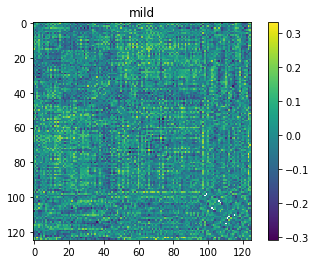

In [25]:
plt.imshow(dic_ciCOH['ciCOH_mild']);
plt.colorbar()
plt.title('mild')
plt.show()

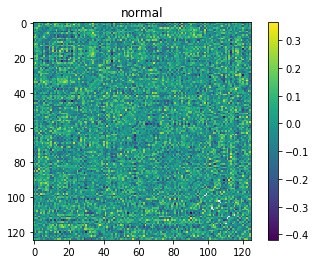

In [26]:
plt.imshow(dic_ciCOH['ciCOH_normal'])
plt.title('normal')
plt.colorbar()
plt.show()